In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

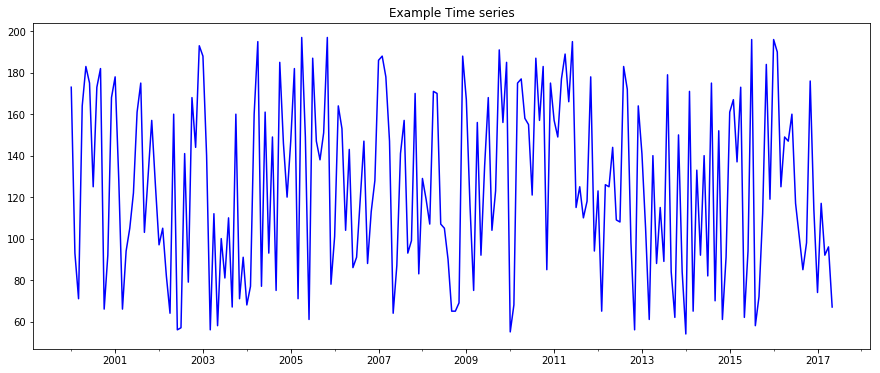

2000-01-31    173
2000-02-29     93
2000-03-31     71
2000-04-30    164
2000-05-31    183
2000-06-30    175
2000-07-31    125
2000-08-31    173
2000-09-30    182
2000-10-31     66
Freq: M, dtype: int32

In [12]:
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.randint(54, 200, size=len(rng)), rng)
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
# data = pd.read_csv('./data/hotelguests.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)
# print(data.head())
# print(data.index)
# ts = data['#guests']
ts.plot(c='b', title='Example Time series')
plt.show()
ts.head(10)

In [13]:
TS = np.array(ts)
num_periods = 6
f_horizon = 1
x_data = TS[:(len(TS)-(len(TS)% num_periods))]
x_batches = x_data.reshape(-1, 6, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 6, 1)
print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

34
(34, 6, 1)
[[[173]
  [ 93]
  [ 71]
  [164]
  [183]
  [175]]

 [[125]
  [173]
  [182]
  [ 66]
  [ 92]
  [168]]]
[[[ 93]
  [ 71]
  [164]
  [183]
  [175]
  [125]]]
(34, 6, 1)


In [14]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 6, 1)
    testY = TS[-(num_periods):].reshape(-1, 6, 1)
    return testX,testY
X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 6, 1)
[[[176]
  [114]
  [ 74]
  [117]
  [ 92]
  [ 96]]]


In [18]:
tf.reset_default_graph()

num_periods = 6
inputs = 1
hidden = 100
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
#BasicRNNCell
learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output,[-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y ))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [19]:
epochs = 3000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 2912162.8
100 	MSE: 531922.75
200 	MSE: 310781.97
300 	MSE: 227539.34
400 	MSE: 193372.8
500 	MSE: 187606.86
600 	MSE: 142636.94
700 	MSE: 127801.3
800 	MSE: 120174.54
900 	MSE: 107083.766
1000 	MSE: 103102.734
1100 	MSE: 92630.266
1200 	MSE: 135707.25
1300 	MSE: 115367.19
1400 	MSE: 90417.76
1500 	MSE: 88204.85
1600 	MSE: 83563.125
1700 	MSE: 87387.55
1800 	MSE: 86314.516
1900 	MSE: 77984.516
2000 	MSE: 77924.914
2100 	MSE: 72929.73
2200 	MSE: 90042.05
2300 	MSE: 70675.945
2400 	MSE: 68669.234
2500 	MSE: 67308.49
2600 	MSE: 65925.26
2700 	MSE: 389956.88
2800 	MSE: 95766.57
2900 	MSE: 80809.31
[[[141.30646]
  [ 78.65526]
  [171.71632]
  [173.23311]
  [298.42514]
  [285.00986]]]


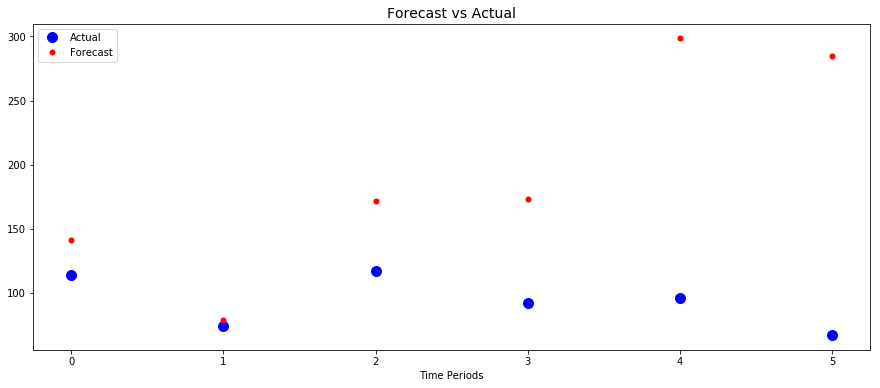

In [20]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()